# Optimizer Comparison Visualization for Single Parameter

Interactive plot showing cumulative updates for a single parameter. The gradients for the parameter are random values with a normal distribution. The optimizers are SGD + momentum, Adam, and Adamax. 

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import Button, Slider

In [2]:
class Adam(object):
    """Calculate single paramter Adam/Adamax updates."""
    
    def __init__(self, beta_1=0.9, beta_2=0.999, epsilon=1e-08):
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.m = 0 # 1st moment vector
        self.v = 0 # 2nd moment vector
        self.v_max = 0 # exponentially weighted infinity norm
        self.t = 0 # timestep
    
    def update(self, gradient, lr, use_denominator=True):
        """Adam and Adamax update for single parameter.
        
        # Arguments
            gradient: float
            lr: float, learning rate
            
        Returns tuple with Adam update first.
        """      
        
        self.t += 1
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * gradient
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * np.square(gradient)
        self.v_max = np.maximum((self.beta_2 * self.v_max), np.abs(gradient))
        m_hat = self.m / (1. - self.beta_1**self.t) # bias correction 
        v_hat = self.v / (1. - self.beta_2**self.t) # bias correction
        
        adam = -lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        adamax = -lr * m_hat / (self.v_max + self.epsilon)

        return (adam, adamax)
    
    
class SGD(object):
    """Calculate single paramter SGD updates with optional momentum."""
    
    def __init__(self, momentum=0):
        self.momentum = momentum
        self.prev_update = 0
    
    def update(self, gradient, lr):
        """Returns SGD update for single parameter.
        
        # Arguments
            gradient: float
            lr: float, learning rate
        """
        
        update = self.momentum * self.prev_update - lr * gradient
        self.prev_update = update
        return update  

<IPython.core.display.Javascript object>


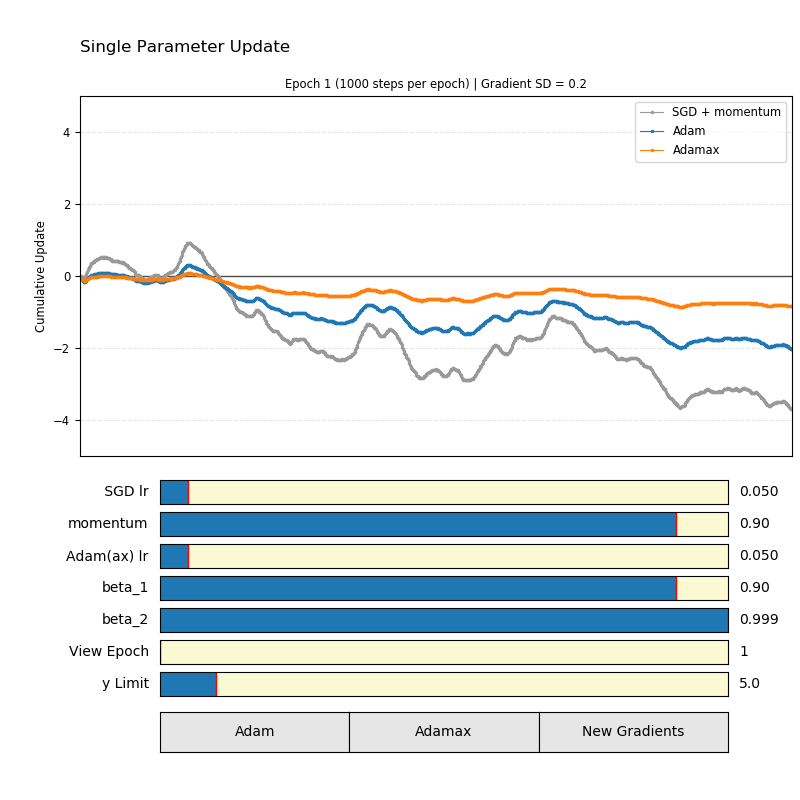

In [3]:
# initial conditions
scale = 0.2 # gradient standard deviation
sgd_lr = 0.05
momentum = 0.9
adam_lr = 0.05
beta_1 = 0.9
beta_2 = 0.999
view_epoch = 1
ylim = 5.
line_width = 1.
epochs = 5
steps_per_epoch = 1000

# static
iterations = epochs * steps_per_epoch

plt.rcParams['figure.figsize'] = (8.0, 8.0)
fig, ax = plt.subplots(nrows=1)
plt.subplots_adjust(left=0.1, right=0.99, bottom=0.43, hspace=0)

ax.axis([0, steps_per_epoch + 1, -ylim, ylim])
ax.grid(axis='y', color='0.9', linestyle='--')
ax.hlines(0, 0, steps_per_epoch + 1, color='0.3', linewidth=1)
ax.set_ylabel('Cumulative Update', fontsize='small')
ax.tick_params(bottom=False, labelbottom=False, labelsize='small')

# updatable
gradients = np.random.normal(scale=scale, size=iterations)
#gradients = np.random.uniform(low=-1, high=1, size=iterations)

sgd = SGD(momentum=momentum)
updates = [sgd.update(g, sgd_lr) for g in gradients]
updates = np.cumsum(updates)
sgd_steps, = ax.plot(
    np.arange(1, steps_per_epoch + 1, 1), 
    updates[steps_per_epoch*(view_epoch-1):steps_per_epoch*view_epoch], 
    color='0.6', label='SGD + momentum', 
    linewidth=0.8, marker='.', markersize=3)

optimizer = Adam(beta_1=beta_1, beta_2=beta_2)
adam, adamax = zip(*[optimizer.update(g, adam_lr) for g in gradients])
adam = np.cumsum(adam)
adamax = np.cumsum(adamax)
adam_steps, = ax.plot(
    np.arange(1, steps_per_epoch + 1, 1), 
    adam[steps_per_epoch*(view_epoch-1):steps_per_epoch*view_epoch], 
    label='Adam', linewidth=0.8, marker='.', markersize=3)
adamax_steps, = ax.plot(
    np.arange(1, steps_per_epoch + 1, 1), 
    adamax[steps_per_epoch*(view_epoch-1):steps_per_epoch*view_epoch], 
    label='Adamax', linewidth=0.8, marker='.', markersize=3)

# legends
ax.set_title("Epoch " + str(view_epoch) + 
             " (" + str(steps_per_epoch) + " steps per epoch)" +
             " | Gradient SD = " + str(round(scale, 4)), fontsize='small')
ax.legend(fontsize='small')

# controls
axcolor = 'lightgoldenrodyellow'
top = 0.41
slider_width = 0.71

ax_sgd_lr = plt.axes([0.2, top - 0.04, slider_width, 0.03], facecolor=axcolor)
ax_momentum = plt.axes([0.2, top - 2*0.04, slider_width, 0.03], facecolor=axcolor)
ax_adam_lr = plt.axes([0.2, top - 3*0.04, slider_width, 0.03], facecolor=axcolor)
ax_beta_1 = plt.axes([0.2, top - 4*0.04, slider_width, 0.03], facecolor=axcolor)
ax_beta_2 = plt.axes([0.2, top - 5*0.04, slider_width, 0.03], facecolor=axcolor)
ax_epoch = plt.axes([0.2, top - 6*0.04, slider_width, 0.03], facecolor=axcolor)
ax_ylim = plt.axes([0.2, top - 7*0.04, slider_width, 0.03], facecolor=axcolor)
ax_adam = plt.axes([0.2, top - 8*0.04 - 0.03, slider_width / 3, 0.05], facecolor=axcolor)
ax_adamax = plt.axes([0.2 + slider_width / 3, top - 8*0.04 - 0.03, slider_width / 3, 0.05], facecolor=axcolor)
ax_grad = plt.axes([0.2 + 2 * slider_width / 3, top - 8*0.04 - 0.03, slider_width / 3, 0.05], facecolor=axcolor)

s_sgd_lr = Slider(ax_sgd_lr, ' SGD lr', 0.001, 1.0, valstep=0.001, valinit=sgd_lr, valfmt='%1.3f')
s_momentum = Slider(ax_momentum, 'momentum', 0.0, 0.99, valstep=0.01, valinit=momentum)
s_adam_lr = Slider(ax_adam_lr, 'Adam(ax) lr', 0.001, 1.0, valstep=0.001, valinit=adam_lr, valfmt='%1.3f')
s_beta_1 = Slider(ax_beta_1, 'beta_1', 0.0, 0.99, valstep=0.01, valinit=beta_1)
s_beta_2 = Slider(ax_beta_2, 'beta_2', 0.0, 0.999, valstep=0.001, valinit=beta_2, valfmt='%1.3f')
s_epoch = Slider(ax_epoch, 'View Epoch', 1, epochs, valstep=1, valinit=view_epoch, valfmt='%d')
s_ylim = Slider(ax_ylim, 'y Limit', 0.1, 50, valstep=0.1, valinit=ylim, valfmt='%1.1f')
b_adam = Button(ax_adam, 'Adam', color='0.9', hovercolor='0.8')
b_adamax = Button(ax_adamax, 'Adamax', color='0.9', hovercolor='0.8')
b_grad = Button(ax_grad, 'New Gradients', color='0.9', hovercolor='0.8')

def new_gradients(val):
    global gradients 
    global scale
    scale = np.random.uniform(0.0, 0.3)
    gradients = np.random.normal(scale=scale, size=iterations)
    update_opt(val)    
    
def update_opt(val):
    global updates
    global adam
    global adamax
    
    sgd_lr = s_sgd_lr.val
    momentum = s_momentum.val
    adam_lr = s_adam_lr.val
    beta_1 = s_beta_1.val
    beta_2 = s_beta_2.val    
    
    sgd = SGD(momentum=momentum)
    updates = [sgd.update(g, sgd_lr) for g in gradients] 
    optimizer = Adam(beta_1=beta_1, beta_2=beta_2)    
    adam, adamax = zip(*[optimizer.update(g, adam_lr) for g in gradients])
    updates = np.cumsum(updates)
    adam = np.cumsum(adam)
    adamax = np.cumsum(adamax)
    
    view_epoch(val)
    
def view_epoch(val):
    e = int(s_epoch.val)
    ax.set_title("Epoch " + str(e) + 
             " (" + str(steps_per_epoch) + " steps per epoch)" +
             " | Gradient SD = " + str(round(scale, 4)), fontsize='small')
    sgd_steps.set_ydata(updates[steps_per_epoch*(e-1):steps_per_epoch*e])
    adam_steps.set_ydata(adam[steps_per_epoch*(e-1):steps_per_epoch*e])
    adamax_steps.set_ydata(adamax[steps_per_epoch*(e-1):steps_per_epoch*e])
    fig.canvas.draw_idle()     
    
def draw_adam(val):
    adam_steps.set_visible(not adam_steps.get_visible())
    fig.canvas.draw_idle()
    
def draw_adamax(val):
    adamax_steps.set_visible(not adamax_steps.get_visible())
    fig.canvas.draw_idle()
    
def zoom(val):
    ylim = s_ylim.val
    ax.set_ylim(top=ylim, bottom=-ylim)
    fig.canvas.draw_idle()
  
s_sgd_lr.on_changed(update_opt)
s_momentum.on_changed(update_opt)
s_adam_lr.on_changed(update_opt)
s_beta_1.on_changed(update_opt)
s_beta_2.on_changed(update_opt)
s_epoch.on_changed(view_epoch)
s_ylim.on_changed(zoom)
b_grad.on_clicked(new_gradients)
b_adam.on_clicked(draw_adam)
b_adamax.on_clicked(draw_adamax)

plt.suptitle('Single Parameter Update', x=0.1, y=0.95, ha='left')
plt.show()

## Notes

- New gradients are sampled from a normal distribution with mean 0 and standard deviation sampled from unif(0, 0.3). 
- SGD + momentum is heavily influenced by 'large' gradients, and will shoot off to extreme updates. Try new gradients or manually changing the standard deviation (`scale` in initial conditions) of the gradient's distribution to see this effect. On the other hand, for small gradients SGD + momentum doesn't have much movement compared to Adam/Adamax.
- Generally, Adam updates have at least twice the magnitude of Adamax. This supports the default learning rate for Adamax being twice the rate of Adam's.
- Adamax is more sensitive to changes in `beta_2` than Adam.